In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
import json

from matplotlib.backends.backend_pdf import PdfPages
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import cluster_pairs as cp

import scipy.stats as stats
import scikit_posthocs as sp 
from statannotations.Annotator import Annotator

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order


Data prep

In [2]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

In [ ]:
#load data here 
data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad\M_dprime'
os.makedirs(out_dir, exist_ok=True)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_layer_dict.json", "r") as f:
    ttype_to_layer_dict = json.load(f)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\L23_ttype_rename.json", "r") as f:
    L23_ttype_rename_dict = json.load(f)

#load the data
metadata = pd.read_csv(os.path.join(data_root, 'metadata.csv'))
metadata = metadata.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'})#, "Pinned Structure and Layer": "final_structure"})
metadata = metadata[['specimen_id', 't_type', 'subclass_label']]
metadata['subclass_label'] = metadata['subclass_label'].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
metadata['t_type'] = metadata['t_type'].replace('L5 ET_ME', 'L5 ET(ME)')
metadata.t_type = metadata.t_type.apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata['layer'] = metadata["t_type"].map(ttype_to_layer_dict)
#split Layer 2 and 3 subclass
metadata["layer_subclass"] = metadata.apply(
    lambda row: "L2 IT" if row["layer"] == 'Layer 2'
                else ("L3 IT" if row["layer"] == 'Layer 3'
                      else row["subclass_label"]),
    axis=1
)
metadata['specimen_id'] = metadata['specimen_id'].astype('int')
metadata = metadata.set_index('specimen_id')

#get transcriptomic order (from RD - mostly trying to keep ttypes ordered by depth within subclasses)
ttype_order, subclass_order = get_tx_order()
layer_subclass_order = ['L2 IT'] + [l.replace('L2/3 IT', 'L3 IT') for l in subclass_order]

#get seaad colors 
color_dict = get_seaad_colors()

#get tx order
label_order = {
    'subclass_label' : subclass_order,
    'layer_subclass' : layer_subclass_order,
    't_type' : ttype_order
}

features_filled = pd.read_csv(os.path.join(data_root, 'RawFeatureWide_imputed.csv'), index_col='specimen_id')
features = features_filled.columns.tolist()

data = metadata.merge(features_filled, how='inner', left_index=True, right_index=True)


Calculate d' pairwise for all supertypes in a layer. Then take the avg d' value for each layer and compare them. 

In [ ]:
layer_dprime_dfs = {}
layer_dprime_records = {}
layer_dprime_avgs = {}
layer_dprime_stds = {}
layer_lost_ttypes = []
for layer in data.layer.unique():
    this_data = data[data['layer'] == layer]
    all_ttypes = set(this_data.t_type.unique())

    #select supertypes with at least 5 cells
    min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
    counts = this_data.t_type.value_counts()
    this_data = this_data[this_data.t_type.map(counts) > min_class_size]

    # Find lost t_types
    remaining_ttypes = set(this_data.t_type.unique())
    lost_ttypes = all_ttypes - remaining_ttypes
    if len(lost_ttypes) > 0:
        layer_lost_ttypes.append(counts[counts.values < 3].to_dict())

    #run pairwise dprime on all supertypes in this layer
    clf = RandomForestClassifier(class_weight='balanced_subsample')
    # clf = GaussianNB()
    m_dprime, m_records = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='t_type', details=True)
    m_dprime = m_dprime.abs()

    #average dprime in this layer 
    dprime_vals = m_dprime.values[np.triu_indices_from(m_dprime, k=1)]
    avg_dprime = dprime_vals.mean()
    std_dprime = dprime_vals.std()
    
    #save
    layer_dprime_dfs[layer] = m_dprime
    layer_dprime_records[layer] = m_records
    layer_dprime_avgs[layer] = avg_dprime
    layer_dprime_stds[layer] = std_dprime


In [5]:
#save lost ttypes df
lost_ttypes_df = pd.DataFrame([{"supertype": k, "count": v} for d in layer_lost_ttypes for k, v in d.items()])
lost_ttypes_df.to_csv(os.path.join(out_dir, f'morpho_dprime_filtered_ttypes_n_{min_class_size}.csv'), index=False)

In [6]:
# averages and stds in one DF
layer_stats = pd.DataFrame({
    "layer": list(layer_dprime_avgs.keys()),
    "avg_dprime": list(layer_dprime_avgs.values()),
    "std_dprime": list(layer_dprime_stds.values())
}).sort_values(by="layer")

# full distribution of dprime values (for stats)
all_vals = []
for layer, df in layer_dprime_dfs.items():
    rows, cols = np.triu_indices_from(df, k=1)

    for r, c in zip(rows, cols):

        #get each supertype
        c1 = df.index[r]
        c2 = df.columns[c]

        # get subclass for each supertype
        s1 = metadata.loc[metadata.t_type == c1, "subclass_label"].unique()[0]
        s2 = metadata.loc[metadata.t_type == c2, "subclass_label"].unique()[0]

        all_vals.append({
            "layer": layer,
            "dprime": df.iloc[r, c],
            "cluster_1": c1,
            "cluster_2": c2,
            "subclass_1": s1,
            "subclass_2": s2,
            "same_subclass": s1 == s2,
        })

dprime_long = pd.DataFrame(all_vals).sort_values(by=["layer", "dprime"])

In [7]:
#save dprime long for M, E, ME combined plotting later
dprime_long.to_csv(os.path.join(out_dir, 'dprime_layer_M.csv'), index=False)

Stats

In [8]:
# Global Kruskal-Wallis test
groups = [dprime_long.loc[dprime_long['layer']==layer, "dprime"].values 
          for layer in dprime_long['layer'].unique()]

H, p_kw = stats.kruskal(*groups)
print("Kruskal–Wallis H =", H, "p =", p_kw)


Kruskal–Wallis H = 14.691706469238218 p = 0.005385266729172455


In [9]:
# Dunn’s pairwise test with FDR correction
dunn = sp.posthoc_dunn(dprime_long, val_col="dprime", group_col="layer", p_adjust="fdr_bh")
print(dunn)


          Layer 2   Layer 3   Layer 4   Layer 5   Layer 6
Layer 2  1.000000  0.399575  0.110563  0.117429  0.813279
Layer 3  0.399575  1.000000  0.026070  0.026070  0.296453
Layer 4  0.110563  0.026070  1.000000  0.372147  0.110563
Layer 5  0.117429  0.026070  0.372147  1.000000  0.117429
Layer 6  0.813279  0.296453  0.110563  0.117429  1.000000


Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Layer 3 vs. Layer 4: Custom statistical test, P_val:2.607e-02


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Layer 3 vs. Layer 5: Custom statistical test, P_val:2.607e-02


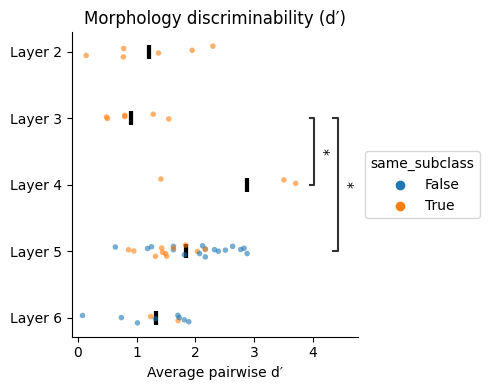

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

#PLOT DATA
sns.stripplot(data=dprime_long, x="dprime", y="layer", hue='same_subclass', size=4, jitter=True, alpha=0.6)
sns.pointplot(data=dprime_long, x='dprime', y='layer', markers="|", scale=1.5, errorbar=None, color='k', join=False, ax=ax)

# #PLOT STATS
all_pairs = [(i, j) for i in layer_stats["layer"] for j in layer_stats["layer"] if i < j]
all_pvals = dunn.values[np.triu_indices_from(dunn, k=1)]

# significant pairs
alpha = 0.05
sig_pairs = [(p, q) for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]
sig_pvals = [pv for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]

# only annotate if there are significant comparisons
if sig_pairs:
    annotator = Annotator(
        ax, 
        sig_pairs, 
        data=dprime_long, 
        x="dprime",    # now the "x" coordinate is the numeric dprime value
        y="layer",      # y is the categorical layer
        orient="h"
    )
    annotator.configure(test=None, text_format="star", loc="inside")
    annotator.set_pvalues(sig_pvals)
    annotator.annotate()

#FORMAT
sns.despine(top=True, right=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="same_subclass")  # outside right
plt.xlabel("Average pairwise d′")
plt.ylabel("")
plt.title("Morphology discriminability (d′)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "morpho_dprime_pairwise_avg_by_layer.pdf"), dpi=600)   # saves current figure as PDF



In [11]:
matrix_colormap = 'rocket' #vidiris #vidiris_r

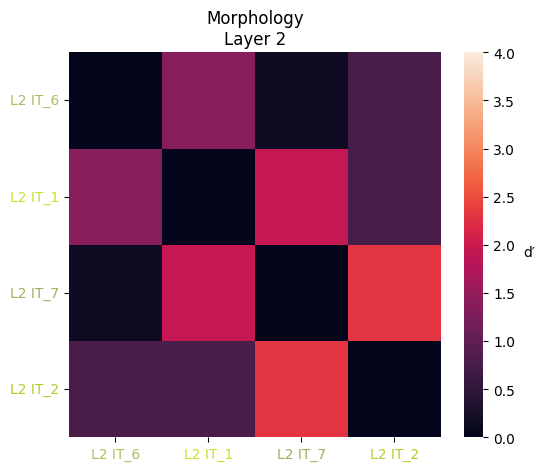

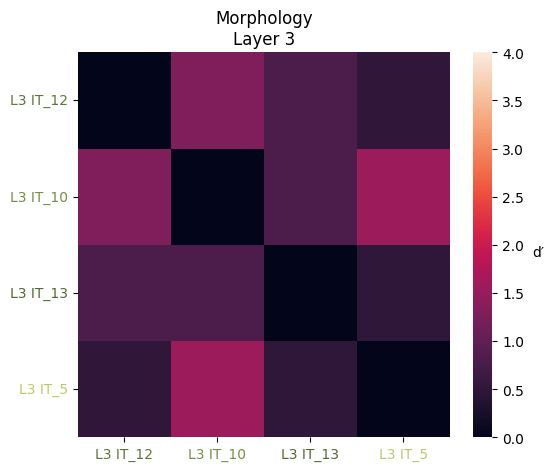

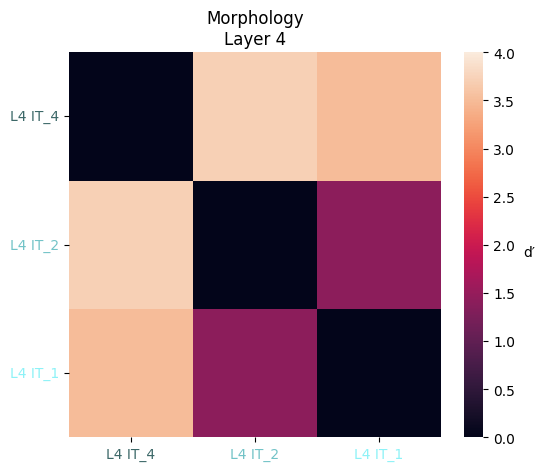

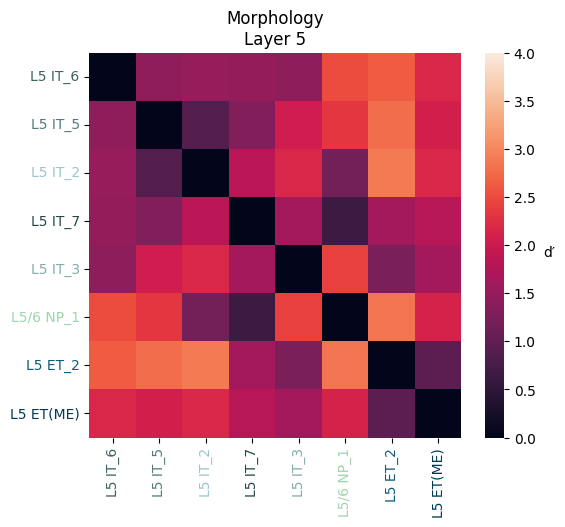

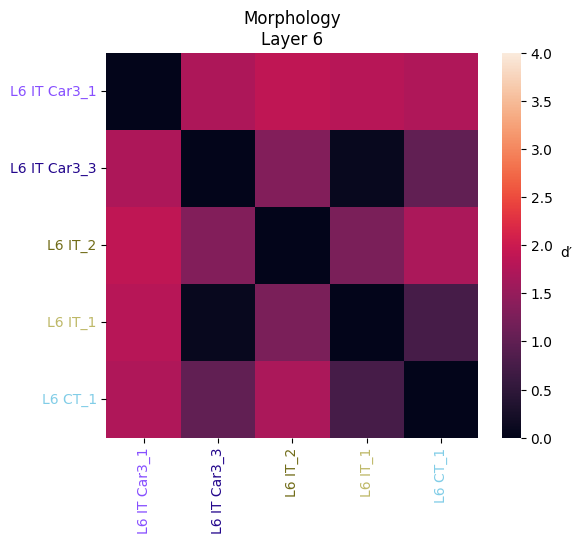

In [12]:
# compute global vmax
all_values = np.concatenate([df.values.flatten() for df in layer_dprime_dfs.values()])
# vmax = all_values.max()
vmax = 4

# open a PDF file
with PdfPages(os.path.join(out_dir, "morpho_dprime_cm_supertypes_by_layer.pdf")) as pdf:
    for i in range(2, 7):
        fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
        df = layer_dprime_dfs[f'Layer {i}']
        label_order = [f for f in ttype_order if f in df.columns]

        heat = sns.heatmap(
            df.loc[label_order, label_order],
            annot=False,
            cmap=matrix_colormap,
            cbar=True,
            vmin=0,
            vmax=vmax,
            ax=ax
        )

        plt.yticks(rotation=0)
        plt.title(f'Morphology\nLayer {i}')

        # color tick labels based on color_dict
        for tick in ax.get_xticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))
        for tick in ax.get_yticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))

        # label the colorbar
        cbar = heat.collections[0].colorbar
        cbar.set_label("d′", rotation=0, labelpad=10)

        pdf.savefig(fig, bbox_inches='tight')   # save this figure to the PDF
        plt.show()
        plt.close(fig)     # close to free memory


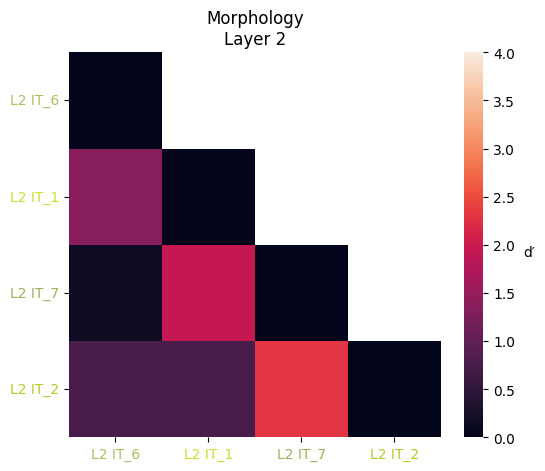

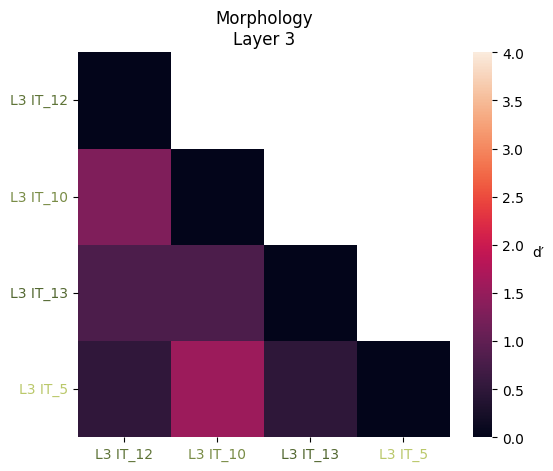

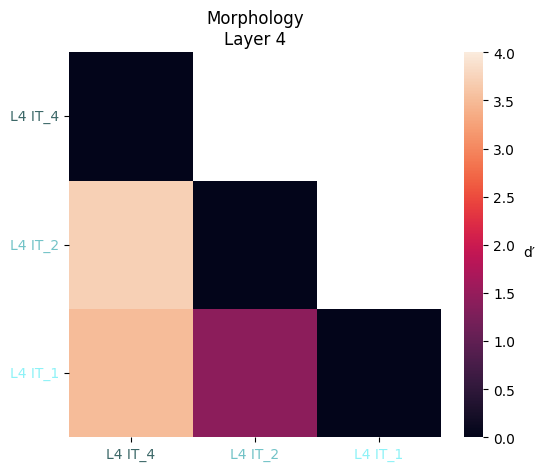

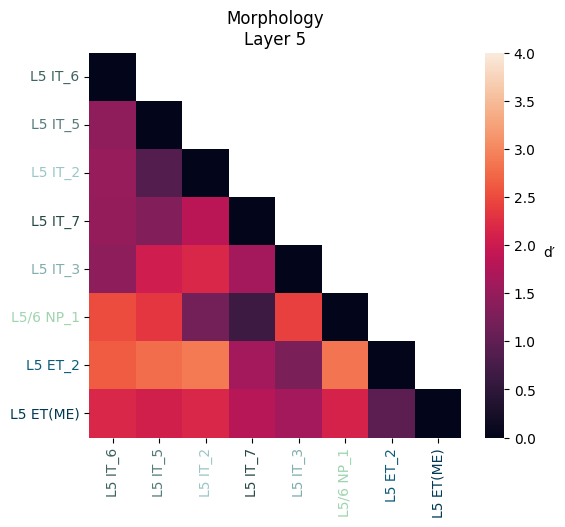

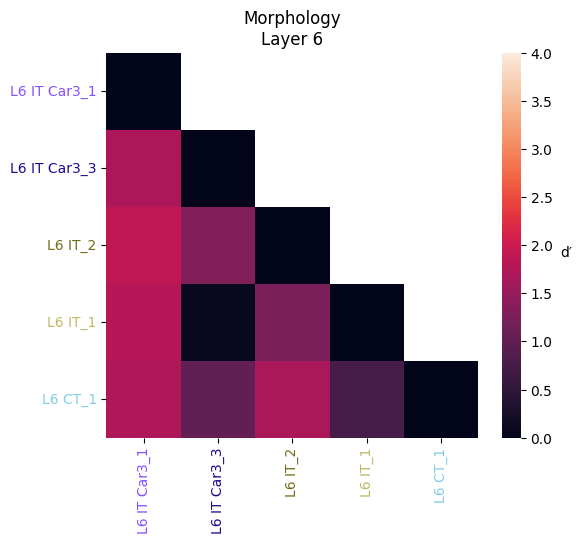

In [13]:
# compute global vmax
all_values = np.concatenate([df.values.flatten() for df in layer_dprime_dfs.values()])
# vmax = all_values.max()
vmax = 4

# open a PDF file
with PdfPages(os.path.join(out_dir, "morpho_dprime_cm_supertypes_by_layer_triangle.pdf")) as pdf:
    for i in range(2, 7):
        fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
        df = layer_dprime_dfs[f'Layer {i}']
        label_order = [f for f in ttype_order if f in df.columns]

        # reorder
        df = df.loc[label_order, label_order]

        # create mask for upper triangle
        mask = np.triu(np.ones_like(df, dtype=bool), k=1)

        heat = sns.heatmap(
            df.loc[label_order, label_order],
            mask=mask,
            annot=False,
            cmap=matrix_colormap,
            cbar=True,
            vmin=0,
            vmax=vmax,
            ax=ax
        )

        plt.yticks(rotation=0)
        plt.title(f'Morphology\nLayer {i}')

        # color tick labels based on color_dict
        for tick in ax.get_xticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))
        for tick in ax.get_yticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))

        # label the colorbar
        cbar = heat.collections[0].colorbar
        cbar.set_label("d′", rotation=0, labelpad=10)

        pdf.savefig(fig, bbox_inches='tight')   # save this figure to the PDF
        plt.show()
        plt.close(fig)     # close to free memory


In [14]:
all_layers = []

for i in range(2, 7):  # layers 2–6
    df = pd.DataFrame(layer_dprime_records[f'Layer {i}'])
    df["layer"] = f"Layer {i}"
    all_layers.append(df)

feature_importance_df = pd.concat(all_layers, ignore_index=True)
feature_importance_df = feature_importance_df[['layer', 'cluster_1', 'cluster_2', 'importance', 'feature']].sort_values(by=['layer', 'cluster_1', 'cluster_2'])

#save
feature_importance_df.to_csv(os.path.join(out_dir, 'morpho_dprime_feature_importance.csv'), index=False)

Calculate d' between all subclasses - transcriptomically defined

In [15]:
#select supertypes with at least 5 cells
min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
counts = data.subclass_label.value_counts()
this_data = data[data.subclass_label.map(counts) > min_class_size]

#run pairwise dprime on all supertypes in this layer
clf = RandomForestClassifier(class_weight='balanced_subsample')
m_dprime_subclass, m_records_subclass = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='subclass_label', details=True)
m_dprime_subclass = m_dprime_subclass.abs()


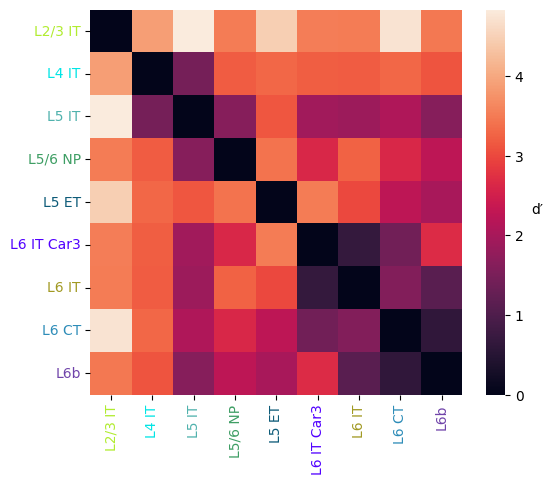

In [16]:
# open a PDF file
with PdfPages(os.path.join(out_dir, "morpho_dprime_cm_subclass.pdf")) as pdf:

    fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
    df = m_dprime_subclass
    label_order = [f for f in subclass_order if f in df.columns]

    heat = sns.heatmap(
        df.loc[label_order, label_order],
        annot=False,
        cmap=matrix_colormap,
        cbar=True,
        # vmin=0,
        # vmax=vmax,
        ax=ax
    )

    plt.yticks(rotation=0)
    # plt.title(f'Layer {i}')

    # color tick labels based on color_dict
    for tick in ax.get_xticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))
    for tick in ax.get_yticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))

    # label the colorbar
    cbar = heat.collections[0].colorbar
    cbar.set_label("d′", rotation=0, labelpad=10)

    pdf.savefig(fig)   # save this figure to the PDF
    plt.show()
    plt.close(fig)     # close to free memory


Calculate d' between all subclasses - layer defined

In [17]:
#select supertypes with at least 5 cells
min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
counts = data.subclass_label.value_counts()
this_data = data[data.subclass_label.map(counts) > min_class_size]

#run pairwise dprime on all supertypes in this layer
clf = RandomForestClassifier(class_weight='balanced_subsample')
m_dprime_layer_subclass, m_records_subclass = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='layer_subclass', details=True)
m_dprime_layer_subclass = m_dprime_layer_subclass.abs()


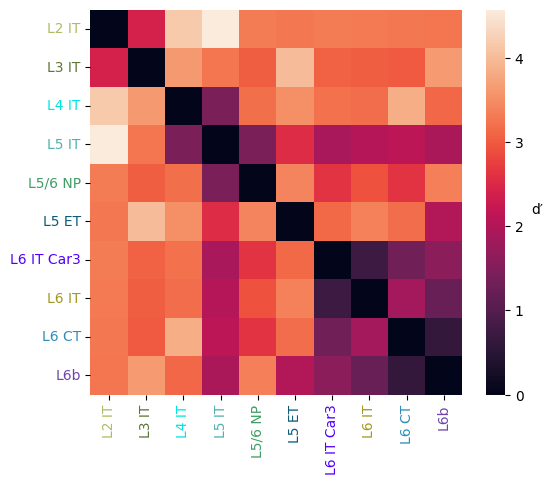

In [18]:
# open a PDF file
with PdfPages(os.path.join(out_dir, "morpho_dprime_cm_layerSubclass.pdf")) as pdf:

    fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
    df = m_dprime_layer_subclass
    label_order = [f for f in layer_subclass_order if f in df.columns]

    heat = sns.heatmap(
        df.loc[label_order, label_order],
        annot=False,
        cmap=matrix_colormap,
        cbar=True,
        # vmin=0,
        # vmax=vmax,
        ax=ax
    )

    plt.yticks(rotation=0)
    # plt.title(f'Layer {i}')

    # color tick labels based on color_dict
    for tick in ax.get_xticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))
    for tick in ax.get_yticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))

    # label the colorbar
    cbar = heat.collections[0].colorbar
    cbar.set_label("d′", rotation=0, labelpad=10)

    pdf.savefig(fig)   # save this figure to the PDF
    plt.show()
    plt.close(fig)     # close to free memory


Calculate d' between all layers

In [19]:
#select supertypes with at least 5 cells
min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
counts = data.layer.value_counts()
this_data = data[data.layer.map(counts) > min_class_size]

#run pairwise dprime on all supertypes in this layer
clf = RandomForestClassifier(class_weight='balanced_subsample')
m_dprime_layer, m_records_layer = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='layer', details=True)
m_dprime_layer = m_dprime_layer.abs()


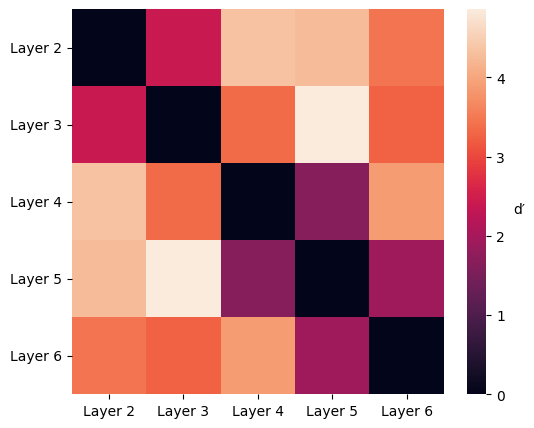

In [20]:
# open a PDF file
with PdfPages(os.path.join(out_dir, "morpho_dprime_cm_layer.pdf")) as pdf:

    fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
    df = m_dprime_layer
    label_order = sorted(df.columns.tolist())

    heat = sns.heatmap(
        df.loc[label_order, label_order],
        annot=False,
        cmap=matrix_colormap,
        cbar=True,
        # vmin=0,
        # vmax=vmax,
        ax=ax
    )

    plt.yticks(rotation=0)
    # plt.title(f'Layer {i}')

    # color tick labels based on color_dict
    for tick in ax.get_xticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))
    for tick in ax.get_yticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))

    # label the colorbar
    cbar = heat.collections[0].colorbar
    cbar.set_label("d′", rotation=0, labelpad=10)

    pdf.savefig(fig)   # save this figure to the PDF
    plt.show()
    plt.close(fig)     # close to free memory


Calculate d' pairwise for all supertypes in a subclass. Then take the avg d' value for each subclass and compare them. 

In [21]:
subclass_dprime_dfs = {}
subclass_dprime_records = {}
subclass_dprime_avgs = {}
subclass_dprime_stds = {}
subclass_lost_ttypes = []
for subclass in data.subclass_label.unique():
    this_data = data[data['subclass_label'] == subclass]
    all_ttypes = set(this_data.t_type.unique())

    if len(all_ttypes) > 1:

        #select supertypes with at least 5 cells
        min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
        counts = this_data.t_type.value_counts()
        this_data = this_data[this_data.t_type.map(counts) > min_class_size]

        if len(this_data) > 0:
            print(subclass)

            # Find lost t_types
            remaining_ttypes = set(this_data.t_type.unique())
            lost_ttypes = all_ttypes - remaining_ttypes
            if len(lost_ttypes) > 0:
                subclass_lost_ttypes.append(counts[counts.values < 3].to_dict())

            #run pairwise dprime on all supertypes in this subclass
            clf = RandomForestClassifier(class_weight='balanced_subsample')
            m_dprime, m_records = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='t_type', details=True)
            m_dprime = m_dprime.abs()

            #average dprime in this subclass 
            dprime_vals = m_dprime.values[np.triu_indices_from(m_dprime, k=1)]
            avg_dprime = dprime_vals.mean()
            std_dprime = dprime_vals.std()
            
            #save
            subclass_dprime_dfs[subclass] = m_dprime
            subclass_dprime_records[subclass] = m_records
            subclass_dprime_avgs[subclass] = avg_dprime
            subclass_dprime_stds[subclass] = std_dprime


L2/3 IT
L4 IT
L6 IT Car3


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the to

L6 IT


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the to

L5/6 NP
L6 CT


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the to

L5 IT
L5 ET


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total

In [22]:
#save lost ttypes df
lost_ttypes_df = pd.DataFrame([{"supertype": k, "count": v} for d in subclass_lost_ttypes for k, v in d.items()])
lost_ttypes_df.to_csv(os.path.join(out_dir, f'morpho_dprime_filtered_ttypes_n_{min_class_size}_subclass.csv'), index=False)

In [23]:
# averages and stds in one DF
subclass_stats = pd.DataFrame({
    "subclass_label": list(subclass_dprime_avgs.keys()),
    "avg_dprime": list(subclass_dprime_avgs.values()),
    "std_dprime": list(subclass_dprime_stds.values())
}).sort_values(by="subclass_label")

# full distribution of dprime values (for stats)
all_vals = []
for subclass, df in subclass_dprime_dfs.items():
    rows, cols = np.triu_indices_from(df, k=1)

    for r, c in zip(rows, cols):

        #get each supertype
        c1 = df.index[r]
        c2 = df.columns[c]

        all_vals.append({
            "subclass_label": subclass,
            "dprime": df.iloc[r, c],
            "cluster_1": c1,
            "cluster_2": c2,
        })

dprime_long = pd.DataFrame(all_vals).sort_values(by=["subclass_label", "dprime"])

In [24]:
#save dprime long for M, E, ME combined plotting later
dprime_long.to_csv(os.path.join(out_dir, 'dprime_subclass_M.csv'), index=False)

Stats

In [25]:
# Global Kruskal-Wallis test
groups = [dprime_long.loc[dprime_long['subclass_label']==subclass, "dprime"].values 
          for subclass in dprime_long['subclass_label'].unique()]

H, p_kw = stats.kruskal(*groups)
print("Kruskal–Wallis H =", H, "p =", p_kw)


Kruskal–Wallis H = 5.092368249717237 p = 0.4047118513895947


In [26]:
# Dunn’s pairwise test with FDR correction
dunn = sp.posthoc_dunn(dprime_long, val_col="dprime", group_col="subclass_label", p_adjust="fdr_bh")
print(dunn)


             L2/3 IT    L4 IT    L5 ET     L5 IT    L6 IT  L6 IT Car3
L2/3 IT     1.000000  0.58049  0.58049  0.715710  0.71571    0.959689
L4 IT       0.580490  1.00000  0.58049  0.580490  0.58049    0.715710
L5 ET       0.580490  0.58049  1.00000  0.580490  0.71571    0.580490
L5 IT       0.715710  0.58049  0.58049  1.000000  0.71571    0.806143
L6 IT       0.715710  0.58049  0.71571  0.715710  1.00000    0.715710
L6 IT Car3  0.959689  0.71571  0.58049  0.806143  0.71571    1.000000


Plot

c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


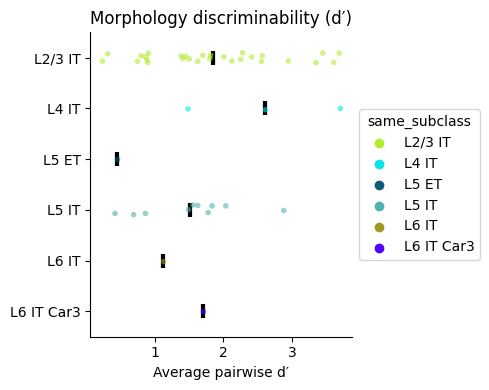

In [27]:
fig, ax = plt.subplots(figsize=(5,4))

#PLOT DATA
sns.stripplot(data=dprime_long, x="dprime", y="subclass_label", hue='subclass_label', palette=color_dict, size=4, jitter=True, alpha=0.6)
sns.pointplot(data=dprime_long, x='dprime', y='subclass_label', markers="|", scale=1.5, errorbar=None, color='k', join=False, ax=ax)

# #PLOT STATS
all_pairs = [(i, j) for i in subclass_stats["subclass_label"] for j in subclass_stats["subclass_label"] if i < j]
all_pvals = dunn.values[np.triu_indices_from(dunn, k=1)]

# significant pairs
alpha = 0.05
sig_pairs = [(p, q) for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]
sig_pvals = [pv for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]

# only annotate if there are significant comparisons
if sig_pairs:
    annotator = Annotator(
        ax, 
        sig_pairs, 
        data=dprime_long, 
        x="dprime",    # now the "x" coordinate is the numeric dprime value
        y="subclass_label",      # y is the categorical layer
        orient="h"
    )
    annotator.configure(test=None, text_format="star", loc="inside")
    annotator.set_pvalues(sig_pvals)
    annotator.annotate()

#FORMAT
sns.despine(top=True, right=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="same_subclass")  # outside right
plt.xlabel("Average pairwise d′")
plt.ylabel("")
plt.title("Morphology discriminability (d′)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "morpho_dprime_pairwise_avg_by_subclass.pdf"), dpi=600)   # saves current figure as PDF



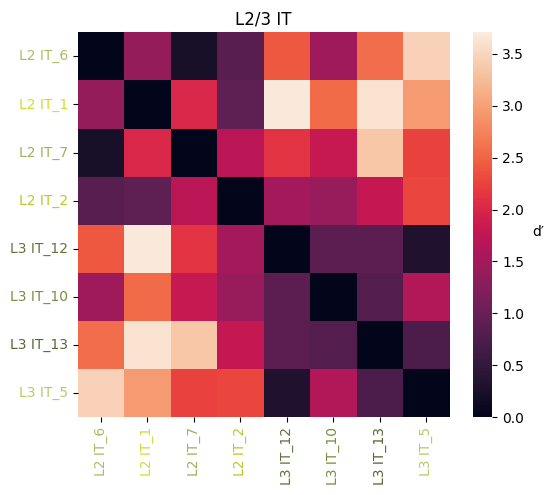

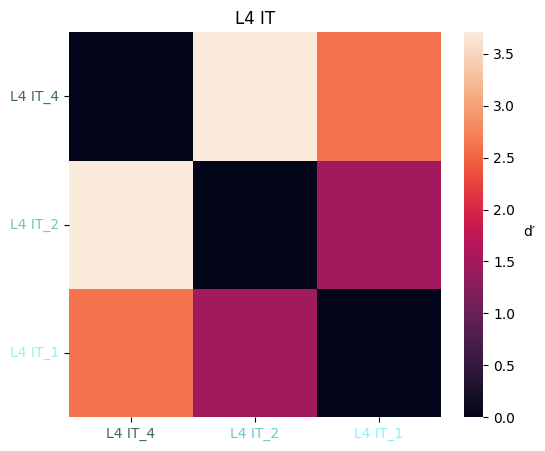

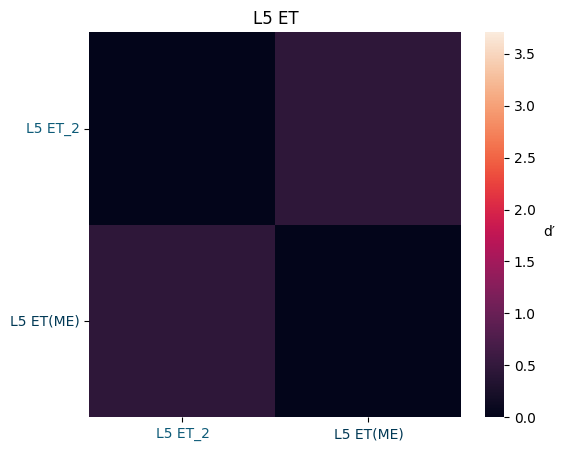

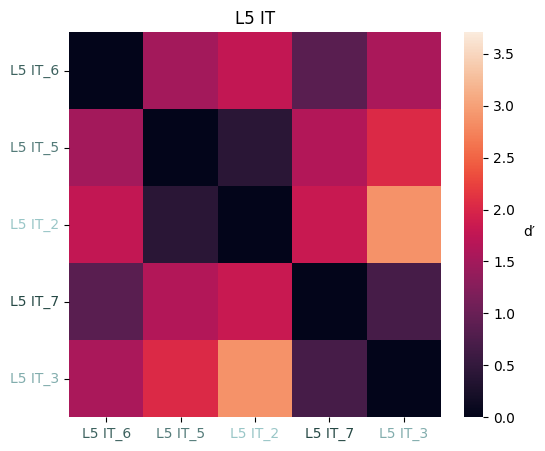

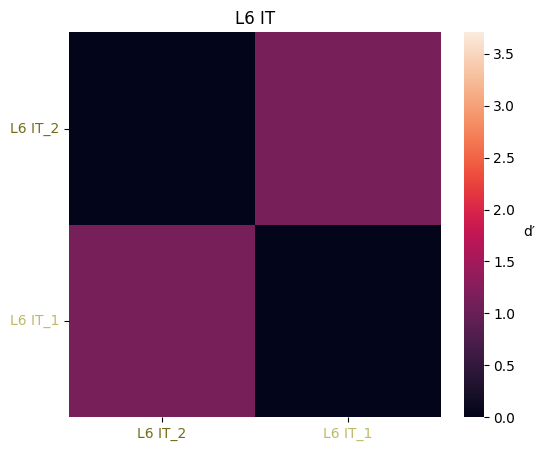

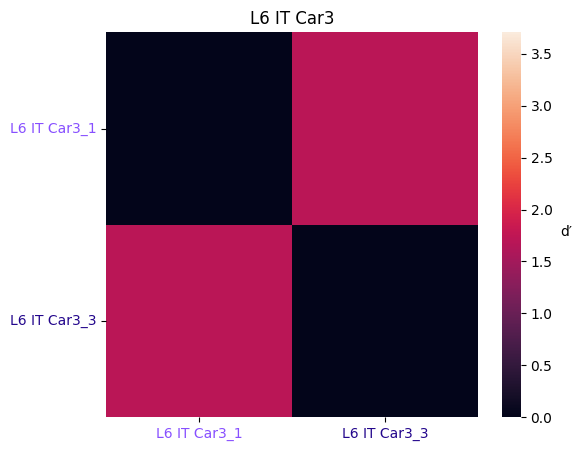

In [28]:
# compute global vmax
all_values = np.concatenate([df.values.flatten() for df in subclass_dprime_dfs.values()])
vmax = all_values.max()

# open a PDF file
with PdfPages(os.path.join(out_dir, "morpho_dprime_cm_supertypes_by_subclass.pdf")) as pdf:
    for subclass in sorted(subclass_dprime_dfs.keys()):
        
        df = subclass_dprime_dfs[subclass]
        if len(df) > 1: #skip subclasses where there's just one ttype

            fig, ax = plt.subplots(figsize=(6,5))  # optional figsize

            subclass_order = [f for f in ttype_order if f in df.columns]

            heat = sns.heatmap(
                df.loc[subclass_order, subclass_order],
                annot=False,
                cmap=matrix_colormap,
                cbar=True,
                vmin=0,
                vmax=vmax,
                ax=ax
            )

            plt.yticks(rotation=0)
            plt.title(subclass)

            # color tick labels based on color_dict
            for tick in ax.get_xticklabels():
                tick.set_color(color_dict.get(tick.get_text(), "k"))
            for tick in ax.get_yticklabels():
                tick.set_color(color_dict.get(tick.get_text(), "k"))

            # label the colorbar
            cbar = heat.collections[0].colorbar
            cbar.set_label("d′", rotation=0, labelpad=10)

            pdf.savefig(fig)   # save this figure to the PDF
            plt.show()
            plt.close(fig)     # close to free memory
